#1.1&nbsp;Neural Networks using Spectograms

In [ ]:
import tensorflow
import os
import cv2
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

Create MEL spectograms and save them as image files

In [ ]:
dataset_path = '/content/drive/MyDrive/GoogleCollab/Data/GTZAN/genres_original'
save_path = '/content/drive/MyDrive/GoogleCollab/Data/GTZAN/spectrograms'

In [ ]:
hop_length = 256
n_fft = 1024
n_mels = 128

In [ ]:
def generate_mel_spectrogram(file_path, save_path):
    y, sr = librosa.load(file_path)

    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=hop_length, n_mels=n_mels)

    mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)

    plt.figure(figsize=(6, 4))
    librosa.display.specshow(mel_spec_db, x_axis='time', y_axis='mel', sr=sr, hop_length=hop_length)
    plt.axis('off')
    plt.savefig(save_path)

    temp_save_path = "temp_spectrogram.png"
    plt.savefig(temp_save_path, bbox_inches='tight', pad_inches=0)
    plt.close()

    img = cv2.imread(temp_save_path, cv2.IMREAD_UNCHANGED)
    non_white_pixels = np.any(img[:, :, :3] < 255, axis=-1)
    coords = np.argwhere(non_white_pixels)
    x0, y0 = coords.min(axis=0)
    x1, y1 = coords.max(axis=0) + 1

    cropped_img = img[x0:x1, y0:y1]
    cv2.imwrite(save_path, cropped_img)

    os.remove(temp_save_path)

In [ ]:
os.makedirs(save_path, exist_ok=True)

for genre in os.listdir(dataset_path):
    genre_path = os.path.join(save_path, genre)
    os.makedirs(genre_path, exist_ok=True)

In [ ]:
for genre_label, genre in enumerate(os.listdir(dataset_path)):
    genre_path = os.path.join(dataset_path, genre)
    for filename in os.listdir(genre_path):
      if filename != 'jazz.00054.wav':
        file_path = os.path.join(genre_path, filename)
        save_file_path = os.path.join(save_path, genre, f"{filename.replace('.wav', '.png')}")
        generate_mel_spectrogram(file_path, save_file_path)

Load spectogram images

In [ ]:
spectogram_data = '/content/drive/MyDrive/GoogleCollab/Data/GTZAN/spectrograms'

In [ ]:
X, y, classes = [], [], []

for label, genre in enumerate(os.listdir(spectogram_data)):
    classes.append(genre)
    genre_path = os.path.join(spectogram_data, genre)

    if os.path.isdir(genre_path):
        for img_file in os.listdir(genre_path):
            img_path = os.path.join(genre_path, img_file)

            if os.path.isfile(img_path):
                img = load_img(img_path, color_mode='grayscale')
                img_array = img_to_array(img)
                X.append(img_array)
                y.append(genre)

X = np.array(X)
y = np.array(y)

np.save('X.npy', X)
np.save('y.npy', y)

print(X.shape, y.shape, classes)

(991, 308, 465, 1) (991,) ['reggae', 'blues', 'metal', 'country', 'rock', 'hiphop', 'classical', 'jazz', 'disco', 'pop']


In [ ]:
X = np.load('X.npy')
y = np.load('y.npy')

Encode labels

In [ ]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded)
print(y_onehot.shape)

(991, 10)


Split data into test & train sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42, shuffle=True)
print(X_train.shape, X_test.shape, y_test.shape)

(792, 308, 465, 1) (199, 308, 465, 1) (199, 10)


Build Neural Network model

In [ ]:
model = Sequential()
model.add(Conv2D(64, 2, activation = 'relu', input_shape = X.shape[1:]))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.1))
model.add(Conv2D(128, 2, activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.1))
model.add(Conv2D(256, 2, activation = 'relu'))
model.add(MaxPooling2D(pool_size = (4,4)))
model.add(Dropout(0.1))
model.add(Conv2D(512, 2, activation = 'relu'))
model.add(MaxPooling2D(pool_size = (8,8)))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(2048, activation = 'relu'))
model.add(Dense(1024, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))

model.add(Dense(10, activation = 'softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 307, 464, 64)      320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 153, 232, 64)      0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 153, 232, 64)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 152, 231, 128)     32896     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 76, 115, 128)      0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 76, 115, 128)     

Compile model

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('model_{accuracy:.4f}.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

Train model

In [ ]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, callbacks=[checkpoint])
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

Epoch 1/50
13/13 [==============================] - ETA: 0s - loss: 2.2318 - accuracy: 0.1503
Epoch 1: val_accuracy improved from -inf to 0.19598, saving model to model_0.1503.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 16s 1s/step - loss: 2.2318 - accuracy: 0.1503 - val_loss: 2.0539 - val_accuracy: 0.1960
Epoch 2/50
13/13 [==============================] - ETA: 0s - loss: 2.0151 - accuracy: 0.2475
Epoch 2: val_accuracy improved from 0.19598 to 0.20101, saving model to model_0.2475.h5
13/13 [==============================] - 13s 1s/step - loss: 2.0151 - accuracy: 0.2475 - val_loss: 2.0469 - val_accuracy: 0.2010
Epoch 3/50
13/13 [==============================] - ETA: 0s - loss: 1.8030 - accuracy: 0.3523
Epoch 3: val_accuracy improved from 0.20101 to 0.32161, saving model to model_0.3523.h5
13/13 [==============================] - 13s 1s/step - loss: 1.8030 - accuracy: 0.3523 - val_loss: 1.7042 - val_accuracy: 0.3216
Epoch 4/50
13/13 [==============================] - ETA: 0s - loss: 1.6062 - accuracy: 0.4141
Epoch 4: val_accuracy improved from 0.32161 to 0.38693, saving model to model_0.4141.h5
13/13 [==============================] - 13s 1s/step - loss: 1.6062

KeyboardInterrupt: ignored

In [ ]:
best_model = tensorflow.keras.models.load_model('best_model_256.h5')
predict_results = best_model.predict(X_test)

y_pred = np.argmax(predict_results, axis=1)
y_test = np.argmax(y_test, axis=1)

7/7 [==============================] - 1s 74ms/step


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=classes)
print(report)
print(f'Accuracy: {accuracy:.4f}')

              precision    recall  f1-score   support

      reggae       0.56      0.36      0.43        14
       blues       0.81      1.00      0.89        17
       metal       0.35      0.42      0.38        19
     country       0.48      0.88      0.62        24
        rock       0.72      0.75      0.73        24
      hiphop       0.86      0.63      0.73        19
   classical       0.85      0.81      0.83        21
        jazz       0.50      0.20      0.29        20
       disco       0.64      0.33      0.44        21
         pop       0.42      0.50      0.45        20

    accuracy                           0.60       199
   macro avg       0.62      0.59      0.58       199
weighted avg       0.62      0.60      0.58       199

Accuracy: 0.5980


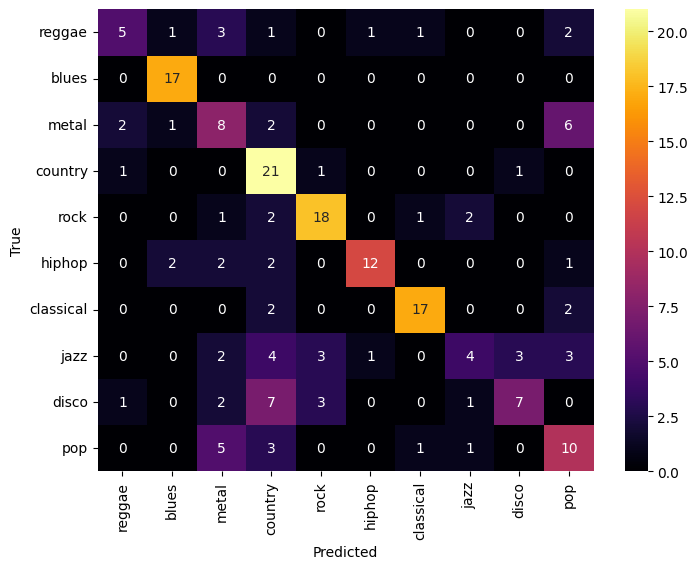

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='inferno', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()